# 다항회귀 + 모듈화

> 

## #01. 준비작업

### [1] 패키지 가져오기

In [22]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.tensor import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터셋 준비하기

In [13]:
origin = my_read_excel('https://data.hossam.kr/mldata/fish.xlsx', info=False)

## #02. 데이터 전처리

### [1] 데이터 스케일링

In [14]:
df = my_minmax_scaler(data=origin, yname='무게')

my_pretty_table(data=df.head())

+----+----------+----------+-----------+--------+
|    |     길이 |     높이 |      두께 |   무게 |
|----+----------+----------+-----------+--------|
|  0 |        0 |        0 |         0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 |     70 |
+----+----------+----------+-----------+--------+


### [2] 다항식으로 변환

In [15]:
df2 = my_poly_features(data=df, ignore=['무게'])
my_pretty_table(data=df2.head())

+----+----------+----------+-----------+-----------+-------------+-------------+-----------+-------------+------------+--------+
|    |     길이 |     높이 |      두께 |    길이^2 |   길이 높이 |   길이 두께 |    높이^2 |   높이 두께 |     두께^2 |   무게 |
|----+----------+----------+-----------+-----------+-------------+-------------+-----------+-------------+------------+--------|
|  0 |        0 |        0 |         0 |         0 |           0 |           0 |         0 |           0 |          0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 | 0.0221642 |   0.0197759 |   0.0130516 |  0.017645 |   0.0116452 | 0.00768553 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 | 0.0343707 |    0.029656 |   0.0280982 |  0.025588 |    0.024244 |  0.0229705 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 | 0.0480053 |   0.0508298 |   0.0397182 | 0.0538205 |   0.0420551 |  0.0328617 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 | 0.0639124 |   0.0586498 |   0.0574737 | 0.0538205 |   0.0527412 |  0.0516836 |    

### [3] 다중공선성 제거

In [16]:
df3 = my_vif_filter(df2, yname = '무게')
my_pretty_table(df3.head())

+----+----------+------------+--------+
|    |     높이 |     두께^2 |   무게 |
|----+----------+------------+--------|
|  0 |        0 |          0 |    5.9 |
|  1 | 0.132834 | 0.00768553 |     32 |
|  2 | 0.159963 |  0.0229705 |     40 |
|  3 | 0.231993 |  0.0328617 |   51.5 |
|  4 | 0.231993 |  0.0516836 |     70 |
+----+----------+------------+--------+


### [5] 훈련/검증 데이터 분할

In [17]:
x_train, x_test, y_train, y_test = my_train_test_split(df3, '무게')
rows, cols = x_train.shape

## #03. 훈련 모델 적합

### [1] 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

In [18]:
model = tf_create(
    dense=[{"units": 64, "activation": "relu", "input_shape": (cols,)},
           {"units": 32, "activation": "relu"},
           {"units": 1, "activation": "linear"}],
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### [2] 학습하기

In [19]:
%%time
result = tf_train(model, x_train, y_train, x_test, y_test)
result

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 50868.5 | 204.384 |
| test  | 26554.4 | 158.516 |
+-------+---------+---------+
CPU times: total: 8.77 s
Wall time: 8.26 s


### [3] 학습 결과 평가

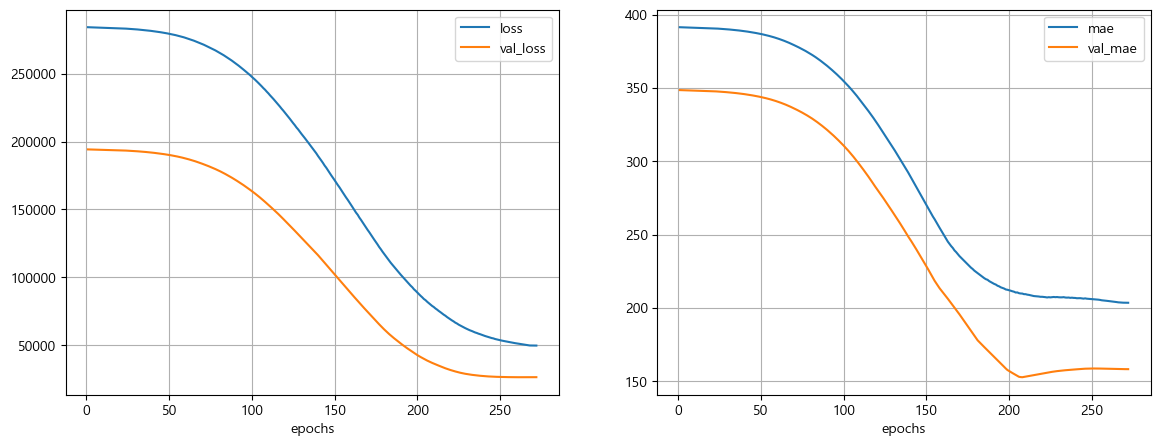

+----------+---------+---------+------------+-----------+--------+
|   epochs |    loss |     mae |   val_loss |   val_mae |     lr |
|----------+---------+---------+------------+-----------+--------|
|        1 |  284111 | 391.465 |     194195 |   348.594 |  0.001 |
|        2 |  284069 | 391.426 |     194161 |   348.557 |  0.001 |
|        3 |  284025 | 391.388 |     194128 |   348.521 |  0.001 |
|        4 |  283985 | 391.352 |     194097 |   348.487 |  0.001 |
|        5 |  283946 | 391.317 |     194066 |   348.453 |  0.001 |
|        6 |  283908 | 391.283 |     194036 |    348.42 |  0.001 |
|        7 |  283873 | 391.251 |     194006 |   348.388 |  0.001 |
|        8 |  283836 | 391.219 |     193976 |   348.356 |  0.001 |
|        9 |  283798 | 391.186 |     193947 |   348.325 |  0.001 |
|       10 |  283764 | 391.155 |     193916 |   348.293 |  0.001 |
|       11 |  283722 | 391.121 |     193886 |   348.261 |  0.001 |
|       12 |  283685 | 391.089 |     193856 |   348.229 |  0.0

In [20]:
tf_result(result)

## #04. 최종 모듈 확인

### [1] 텐서 범용 함수

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 51846.8 | 205.566 |
| test  | 26710.8 | 159.042 |
+-------+---------+---------+


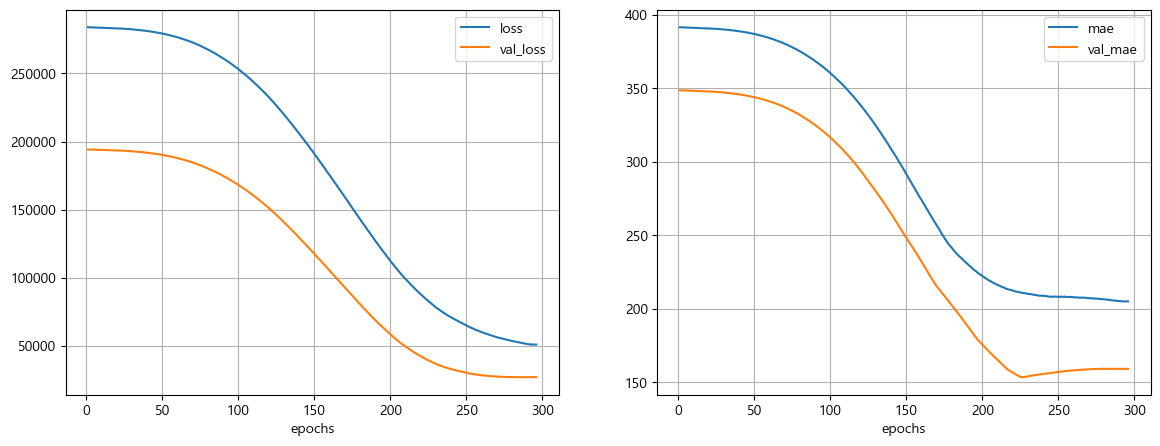

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                192       
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    dense=[
        {"units": 64, "activation": "relu", "input_shape": (cols,)},
        {"units": 32, "activation": "relu"},
        {"units": 1, "activation": "linear"},
    ],
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
).summary()

### [2] 선형 회귀 함수

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 51846.8 | 205.566 |
| test  | 26710.8 | 159.042 |
+-------+---------+---------+


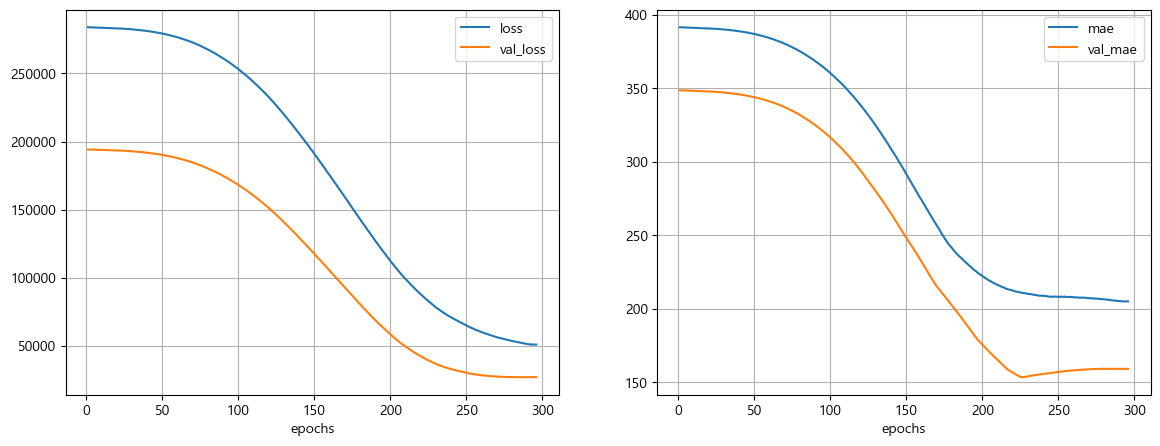

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                192       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
tb_path = "D:\\tensorboard\\"
my_tf_linear(x_train, y_train, x_test, y_test, tensorboard_path=tb_path).summary()

## #06. Tensorboard 가동

vscode Tensorboard Extension 설치 후 수행